In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

#size of training dataset
train_samples = train.shape[0]

In [2]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [4]:
train.groupby(by='Survived').PassengerId.count()

# double number of not survived that survived

Survived
0    549
1    342
Name: PassengerId, dtype: int64

In [6]:
train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1]  ).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def scale(X):
    # Input is a dataframe
    #
    # Note the way of scaling (df[df.columns])
    # we want to mantain the dataframe (instead of numpy array)
    if fit_scaler:
        X[X.columns] = scaler.fit_transform(X[X.columns])
    else:
        X[X.columns] = scaler.transform(X[X.columns])
        
    return X 

def preprocess(df, fit_scaler=True):
    #X = df[['Pclass','Age','SibSp','Parch','Fare','Sex', 'Embarked']]
    X = df[['Pclass','Sex']].copy()

    # feature engineering
    X.Sex = X.Sex.map({'female':1, 'male':0})
    #X.Embarked.fillna('U', inplace=True)
    #X.Embarked = X.Embarked.map({'S':0,'C':1,'Q':2,'U':3})
    
    X['Family'] = df.Parch + df.Parch
    #mask = (df.Parch>0) & (df.SibSp>0)
    #X.loc[mask, 'Family'] = 1
    
    #X['Name'] = train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1])
    #list_names = train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1]).unique()
    #dict_names = {v:k for k,v in enumerate(list_names)}
    #X.Name = X.Name.map(dict_names)
    
    #fill NaN Age with the mean of the same name ('Mr', 'Miss',...)
    #grp_name_age = X.groupby(by='Name').Age.mean()
    #X['Age'] = np.where(X.Age.isnull(), grp_name_age[X.Name], X.Age)
    
    #X = X.drop('Name',axis=1)
    
    return X


X_train = preprocess(train)
y_train = train[['Survived']]

<IPython.core.display.Javascript object>


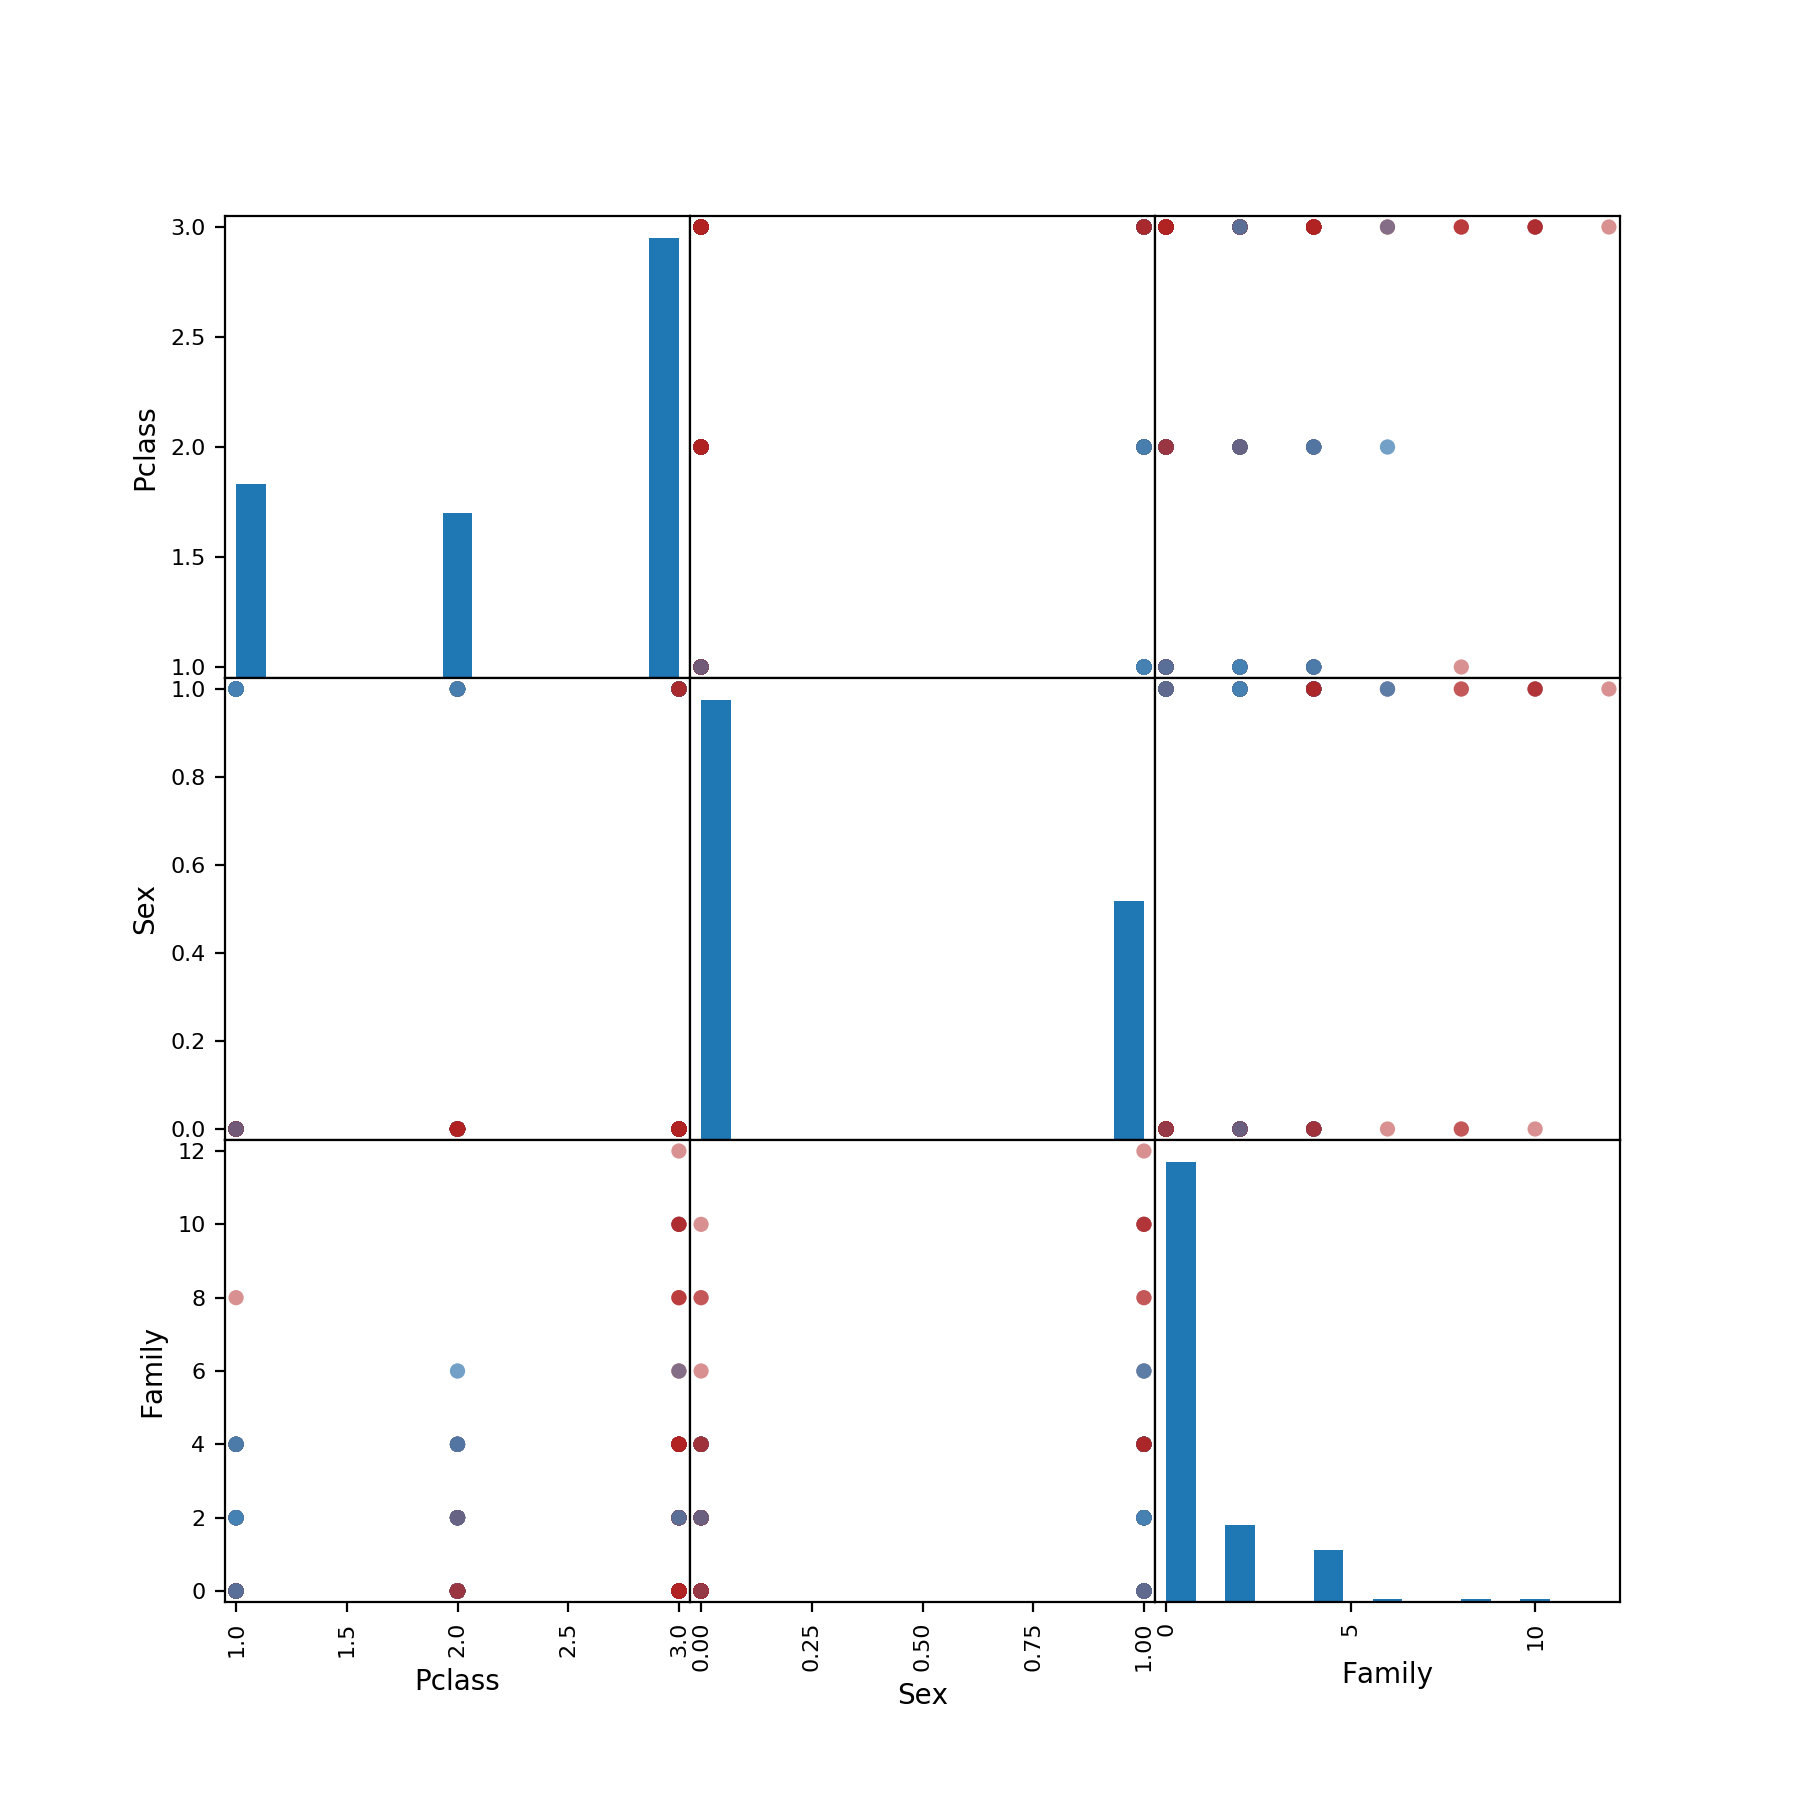

In [10]:
# plotting a scatter matrix
colormap = {0:'firebrick',1:'steelblue'}
colors = y_train.Survived.map(colormap)

pd.plotting.scatter_matrix(X_train, c=colors, marker = 'o', s=30,
                           hist_kwds={'bins':15}, figsize=(9,9));



In [34]:
#baseline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

def baseline(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

    dummy = DummyClassifier(random_state=0)

    #be aware of y as column vector
    dummy.fit(X_train, y_train.values.reshape(-1))
    acc = dummy.score(X_val.values, y_val.values.reshape(-1))
    print('Accuracy: {:.2f}\n'.format(acc))
    
    # Combined report with all above metrics
    print(classification_report(y_val, dummy.predict(X_val), target_names=['Not Survived', 'Survived']))

baseline(X_train, y_train)

Accuracy: 0.54

              precision    recall  f1-score   support

Not Survived       0.63      0.62      0.63       139
    Survived       0.39      0.40      0.40        84

 avg / total       0.54      0.54      0.54       223



## Baseline starts from 0.54

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

X_train_1 = X_train.values
y_train_1 = y_train.values.reshape(-1)

rfc = RandomForestClassifier(random_state=0)
scores = cross_validate(rfc, X_train_1, y_train_1, cv=10, scoring='accuracy')

print("Train scores: {:.3f}".format(scores['train_score'].mean()))
print("Test scores: {:.3f}".format(scores['test_score'].mean()))

Train scores: 0.807
Test scores: 0.795


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score

def grid_search(X, y):
    max_range = np.append(np.arange(1, X_train_1.shape[1]+1), None)
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    params = {'n_estimators': [2, 3, 5],
              'class_weight': ['balanced', {1:2}, {1:3}],
              'max_features': max_range,
              'max_depth': max_range}

    grid_rfc = GridSearchCV(rfc, param_grid=params, cv=10, scoring='accuracy')
    grid_rfc.fit(X_train, y_train)

    best_rfc = grid_rfc.best_estimator_

    y_pred = best_rfc.predict(X_val)
    print("Accuracy: {:.3f}".format(accuracy_score(y_val, y_pred)))

    y_probs = best_rfc.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_probs[:,1])
    print("AUC:{:.3f}".format(auc))
    
    print("Best params:\n {}".format(grid_rfc.best_params_))
    print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))
    
    return best_rfc

best_rfc = grid_search(X_train_1, y_train_1)

Accuracy: 0.785
AUC:0.864
Best params:
 {'class_weight': 'balanced', 'max_depth': None, 'max_features': 2, 'n_estimators': 5}
              precision    recall  f1-score   support

Not Survived       0.82      0.83      0.83       139
    Survived       0.72      0.70      0.71        84

 avg / total       0.78      0.78      0.78       223



In [29]:
scores = cross_validate(best_rfc, X_train_1, y_train_1, cv=10, scoring='accuracy')

print("Train scores: {:.3f}".format(scores['train_score'].mean()))
print("Test scores: {:.3f}".format(scores['test_score'].mean()))

Train scores: 0.794
Test scores: 0.764


In [32]:
def save_to_file():
    import os

    X_test = preprocess(test, fit_scaler=False)
    predictions = best_rfc.predict(X_test)

    passengerId = 892
    file = "PassengerId,Survived" + os.linesep

    for i in range(len(X_test)):
        file += "{},{}".format(passengerId, (int)(predictions[i]))  + os.linesep
        passengerId += 1

    # Save to file
    with open('attempt.txt', 'w') as f:
        f.write(file)

In [33]:
save_to_file()

## 0.77511 in Kaggle!!!